# Multi-Year WAR/162 Projection with Bat-Tracking Backfill

This notebook predicts **next-year WAR per 162 games (WAR/162)** from **current-year features**
using a multi-year hitter-by-year dataset:

`data/Hitters_2015-2025_byYear_retry.csv`

We build a year *t* → year *t+1* panel and compare three bat-tracking strategies:

A. `no_bat` – drop all bat-tracking features.
B. `median_impute` – keep bat-tracking features, impute missing values with the median.
C. `player_backfill` – for bat-tracking features, fill missing values for a player with that player's
   mean bat-tracking stats across all years where they exist (this uses information from other seasons
   for the same player and is optimistic / slightly leaky, but gives an upper bound on what bat tracking
   could add).

For each bat strategy we run two feature sets:

- `skill_only`: excludes current-year WAR and WAR_per_162 from features.
- `with_prev_war`: includes current-year WAR and WAR_per_162 as predictors.

Models:

- **ElasticNetCV** (regularized linear regression)
- **MLPRegressor** (feedforward neural net)


In [178]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)

# Define root_mean_squared_error for compatibility with older sklearn versions
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hyperparameter tuning settings
ALPHA_RANGE = np.logspace(-3, 1, 20)  # Range of alpha values to try
L1_RATIO_RANGE = [0.1, 0.3, 0.5, 0.7, 0.9]  # Range of l1_ratio values to try
MIN_PA_TRAIN = 200  # Minimum PA threshold for training data


## 1. Load dataset and compute WAR_per_162

In [179]:
data_path = 'data/Hitters_2015-2025_byYear_retry.csv'
df = pd.read_csv(data_path)
print('Shape:', df.shape)
print('Columns (first 20):', list(df.columns)[:20])
print('\nSeason value counts:')
print(df['Season'].value_counts().sort_index())

df = df.copy()
df['WAR_per_162'] = (df['WAR'] / df['G'].replace(0, np.nan)) * 162
print('\nSample WAR_per_162 rows:')
print(df[['mlbID', 'Season', 'G', 'WAR', 'WAR_per_162']].head())


Shape: (7238, 86)
Columns (first 20): ['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF']

Season value counts:
Season
2015    694
2016    713
2017    699
2018    696
2019    712
2020    521
2021    717
2022    636
2023    618
2024    607
2025    625
Name: count, dtype: int64

Sample WAR_per_162 rows:
    mlbID  Season    G   WAR  WAR_per_162
0  547989    2015  154  3.35     3.524026
1  554429    2015  100 -0.89    -1.441800
2  542436    2015   24  0.04     0.270000
3  571431    2015   60  0.00     0.000000
4  501303    2015   49  0.15     0.495918


In [180]:
min_season, max_season = df['Season'].min(), df['Season'].max()
print('Seasons span:', min_season, 'to', max_season)

# t side: all but last season
df_t = df[df['Season'] < max_season].copy()

# t+1 target side
df_target = df[['mlbID', 'Season', 'WAR_per_162']].copy()
df_target = df_target.rename(columns={'Season': 'Season_next', 'WAR_per_162': 'WAR_per_162_next'})
df_target['Season'] = df_target['Season_next'] - 1

panel = df_t.merge(
    df_target[['mlbID', 'Season', 'Season_next', 'WAR_per_162_next']],
    on=['mlbID', 'Season'],
    how='inner'
)

print('Panel shape (t -> t+1 pairs):', panel.shape)
print('\nPairs by t (Season):')
print(panel['Season'].value_counts().sort_index())
print('\nPairs by t+1 (Season_next):')
print(panel['Season_next'].value_counts().sort_index())

panel = panel.dropna(subset=['WAR_per_162_next'])
print('\nPanel after dropping missing targets:', panel.shape)


Seasons span: 2015 to 2025
Panel shape (t -> t+1 pairs): (4992, 89)

Pairs by t (Season):
Season
2015    536
2016    529
2017    535
2018    545
2019    449
2020    448
2021    478
2022    491
2023    483
2024    498
Name: count, dtype: int64

Pairs by t+1 (Season_next):
Season_next
2016    536
2017    529
2018    535
2019    545
2020    449
2021    448
2022    478
2023    491
2024    483
2025    498
Name: count, dtype: int64

Panel after dropping missing targets: (4992, 89)


## 3. Identify bat-tracking feature columns

We heuristically detect bat-tracking columns by name (adjust as needed).

In [181]:
bat_kw = ['Name_bat','swings_competitive','percent_swings_competitive','contact','avg_bat_speed','hard_swing_rate','squared_up_per_bat_contact','squared_up_per_swing','blast_per_bat_contact','blast_per_swing','swing_length','swords','batter_run_value','whiffs','whiff_per_swing','batted_ball_events','batted_ball_event_per_swing']
all_cols = panel.columns.tolist()
bat_cols = []
for c in all_cols:
    lc = c.lower()
    if any(k in lc for k in bat_kw):
        bat_cols.append(c)

bat_cols = sorted(set(bat_cols))
bat_cols = [c for c in bat_cols if pd.api.types.is_numeric_dtype(panel[c])]
print('Detected bat-tracking numeric columns:', len(bat_cols))
print(bat_cols)


Detected bat-tracking numeric columns: 16
['avg_bat_speed', 'batted_ball_event_per_swing', 'batted_ball_events', 'batter_run_value', 'blast_per_bat_contact', 'blast_per_swing', 'contact', 'hard_swing_rate', 'percent_swings_competitive', 'squared_up_per_bat_contact', 'squared_up_per_swing', 'swing_length', 'swings_competitive', 'swords', 'whiff_per_swing', 'whiffs']


## 4. Define base numeric features

We start with all numeric columns, excluding identifiers, year columns, and the t+1 target.

In [182]:
numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
exclude_base = {'mlbID', 'Season', 'Season_next', 'WAR_per_162_next'}
base_feature_cols = [c for c in numeric_cols if c not in exclude_base]
print('Base numeric feature columns (incl current-year WAR):', len(base_feature_cols))
print(base_feature_cols[:25])


Base numeric feature columns (incl current-year WAR): 76
['Age', '#days', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'swings_competitive']


## 5. Train/test split

- **Train**: all pairs with `Season <= 2023` (predicting up through 2024).
- **Test**: pairs with `Season == 2024` (predicting 2025).

In [183]:
train_panel_raw = panel[panel['Season'] <= 2023].copy()
test_panel_raw = panel[panel['Season'] == 2024].copy()

print('Train panel (raw) shape:', train_panel_raw.shape)
print('Test panel  (raw) shape:', test_panel_raw.shape)


Train panel (raw) shape: (4494, 89)
Test panel  (raw) shape: (498, 89)


## 6. Player-level bat-tracking backfill (strategy C)

**Strategy**: 
1. Bat-tracking data is only available 2023-2025
2. For each player, compute their mean bat-tracking stats from 2023-2025
3. Use those means to backfill earlier years (2015-2023) for players with data
4. For players without bat-tracking data, set to zero (keeps all players)

This uses each player's measured bat-tracking profile to fill in earlier years, and treats missing data as zero for players who never had bat-tracking data.

In [184]:
# Strategy: Bat-tracking data is only available 2023-2025
# For each player, compute their mean bat-tracking stats from 2023-2025
# Use those means to backfill earlier years (2015-2023)
# For players without bat-tracking data, set to zero (keeps all players)

panel_backfilled = panel.copy()

if bat_cols:
    print("Step 1: Computing player-level bat-tracking means from 2023-2025...")
    
    # Get bat-tracking data from 2023-2025 (where it exists)
    bat_data_available = panel_backfilled[panel_backfilled['Season'] >= 2023].copy()
    
    # Compute per-player means from 2023-2025
    player_bat_means = bat_data_available.groupby('mlbID')[bat_cols].mean()
    
    print(f"  Players with bat-tracking data (2023-2025): {len(player_bat_means)}")
    
    print("Step 2: Backfilling earlier years with player means...")
    
    # For each player, fill missing bat-tracking values with their 2023-2025 mean
    for player_id in player_bat_means.index:
        player_mask = panel_backfilled['mlbID'] == player_id
        for c in bat_cols:
            panel_backfilled.loc[player_mask, c] = panel_backfilled.loc[player_mask, c].fillna(
                player_bat_means.loc[player_id, c]
            )
    
    print("Step 3: Setting missing values to zero for players without bat-tracking data...")
    
    # For players without bat-tracking data, use zero
    for c in bat_cols:
        panel_backfilled[c] = panel_backfilled[c].fillna(0)
    
    print(f"  Final dataset: {len(panel_backfilled)} rows (all players kept)")

# Split into train and test
train_panel_backfill = panel_backfilled[panel_backfilled['Season'] <= 2023].copy()
test_panel_backfill = panel_backfilled[panel_backfilled['Season'] == 2024].copy()

print('\nFinal panels:')
print(f'  Train panel (backfilled): {train_panel_backfill.shape[0]} rows, {train_panel_backfill["mlbID"].nunique()} players')
print(f'  Test panel  (backfilled): {test_panel_backfill.shape[0]} rows, {test_panel_backfill["mlbID"].nunique()} players')


Step 1: Computing player-level bat-tracking means from 2023-2025...
  Players with bat-tracking data (2023-2025): 576
Step 2: Backfilling earlier years with player means...
Step 3: Setting missing values to zero for players without bat-tracking data...
  Final dataset: 4992 rows (all players kept)

Final panels:
  Train panel (backfilled): 4494 rows, 1279 players
  Test panel  (backfilled): 498 rows, 498 players


## 7. Helper: run one experiment

We parameterize experiments by:

- `feature_mode`:
  - `'skill_only'`: drop current-year `WAR` and `WAR_per_162` from features.
  - `'with_prev_war'`: keep them as features.
- `bat_strategy`:
  - `'no_bat'`: drop bat-tracking columns from features.
  - `'median_impute'`: use raw panels, impute missing bat data with medians.
  - `'player_backfill'`: use backfilled panels, bat-tracking values already filled.


In [185]:
def run_experiment(train_panel, test_panel, base_feature_cols, bat_cols,
                   feature_mode='skill_only', bat_strategy='no_bat',
                   min_pa_train=MIN_PA_TRAIN, random_state=42):
    """
    Run a single experiment with specified feature mode and bat strategy.
    
    Parameters:
    -----------
    train_panel, test_panel : DataFrame
        Training and test panels
    base_feature_cols : list
        Base numeric feature columns
    bat_cols : list
        Bat-tracking column names
    feature_mode : str
        'skill_only' or 'with_prev_war'
    bat_strategy : str
        'median_impute' or 'player_backfill'
    min_pa_train : int
        Minimum PA threshold for training data (default: 200)
    random_state : int
        Random seed
    """
    # Start from base features
    feature_cols = base_feature_cols.copy()

    # Feature set: skill only vs with previous WAR
    if feature_mode == 'skill_only':
        feature_cols = [c for c in feature_cols if c not in {'WAR', 'WAR_per_162'}]
    elif feature_mode == 'with_prev_war':
        pass
    else:
        raise ValueError(f'Unknown feature_mode: {feature_mode}')

    # Bat strategy: both strategies keep bat features (handled via which panel we pass in)
    if bat_strategy not in {'median_impute', 'player_backfill'}:
        raise ValueError(f'Unknown bat_strategy: {bat_strategy}')

    # Filter training data by PA threshold
    train_panel = train_panel[train_panel['PA'] >= min_pa_train].copy()
    
    # Drop rows with missing target
    train_subset = train_panel.dropna(subset=['WAR_per_162_next']).copy()
    test_subset = test_panel.dropna(subset=['WAR_per_162_next']).copy()

    # Extract numeric features
    X_train_numeric = train_subset[feature_cols].values
    X_test_numeric = test_subset[feature_cols].values
    y_train = train_subset['WAR_per_162_next'].values
    y_test = test_subset['WAR_per_162_next'].values

    # One-hot encode position
    train_pos = train_subset['position'].fillna('DH').values.reshape(-1, 1)
    test_pos = test_subset['position'].fillna('DH').values.reshape(-1, 1)
    
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)
    X_train_pos = ohe.fit_transform(train_pos)
    X_test_pos = ohe.transform(test_pos)
    
    pos_feature_names = [f'pos_{cat}' for cat in ohe.categories_[0]]
    
    # Concatenate numeric and position features
    X_train = np.hstack([X_train_numeric, X_train_pos])
    X_test = np.hstack([X_test_numeric, X_test_pos])

    # Impute + scale
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    # ElasticNetCV: automatically tunes alpha and l1_ratio via cross-validation
    model = ElasticNetCV(
        l1_ratio=L1_RATIO_RANGE,
        alphas=ALPHA_RANGE,
        cv=5,
        random_state=random_state,
        max_iter=2000,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Combine feature names
    all_feature_names = feature_cols + pos_feature_names
    
    return {
        'feature_mode': feature_mode,
        'bat_strategy': bat_strategy,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'feature_count': len(all_feature_names),
        'feature_names': all_feature_names,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'alpha': model.alpha_,  # Tuned alpha from CV
        'l1_ratio': model.l1_ratio_,  # Tuned l1_ratio from CV
        'model': model,
        'imputer': imputer,
        'scaler': scaler,
        'onehot_encoder': ohe,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
    }


## 8. Run experiments for A, B, C × feature modes

Bat strategies:

- A: `no_bat` (raw panels)
- B: `median_impute` (raw panels)
- C: `player_backfill` (backfilled panels)


In [186]:
feature_modes = ['skill_only', 'with_prev_war']
bat_strategies = ['median_impute', 'player_backfill']

print(f"Training filter: >= {MIN_PA_TRAIN} PA")
print(f"Model: ElasticNetCV (tuning alpha and l1_ratio via 5-fold CV)")
print(f"  Alpha range: {ALPHA_RANGE[0]:.3f} to {ALPHA_RANGE[-1]:.3f} ({len(ALPHA_RANGE)} values)")
print(f"  L1 ratio range: {L1_RATIO_RANGE}")
print("="*80)

all_results = []

for fm in feature_modes:
    for bs in bat_strategies:
        print(f"\n=== Running: feature_mode={fm}, bat_strategy={bs} ===")
        if bs == 'median_impute':
            tp = train_panel_raw
            sp = test_panel_raw
        elif bs == 'player_backfill':
            tp = train_panel_backfill
            sp = test_panel_backfill
        else:
            raise ValueError(f"Unknown bat_strategy: {bs}")

        res = run_experiment(tp, sp, base_feature_cols, bat_cols,
                             feature_mode=fm, bat_strategy=bs, random_state=42)
        all_results.append(res)
        print(f"  Tuned: alpha={res['alpha']:.4f}, l1_ratio={res['l1_ratio']:.3f}")

summary_rows = []
for r in all_results:
    summary_rows.append({
        'feature_mode': r['feature_mode'],
        'bat_strategy': r['bat_strategy'],
        'n_train': r['n_train'],
        'n_test': r['n_test'],
        'feature_count': r['feature_count'],
        'test_rmse': r['test_rmse'],
        'test_r2': r['test_r2'],
        'alpha': r['alpha'],
        'l1_ratio': r['l1_ratio'],
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by='test_r2', ascending=False)
summary_df


Training filter: >= 200 PA
Model: ElasticNetCV (tuning alpha and l1_ratio via 5-fold CV)
  Alpha range: 0.001 to 10.000 (20 values)
  L1 ratio range: [0.1, 0.3, 0.5, 0.7, 0.9]

=== Running: feature_mode=skill_only, bat_strategy=median_impute ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.2403355656661, tolerance: 1.87623887324188
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.785704744515897, tolerance: 1.8210933571757
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2979329199388303, tolerance: 1.87623887324188
  model = cd_fast.enet_coordinate_de

  Tuned: alpha=0.0043, l1_ratio=0.900

=== Running: feature_mode=skill_only, bat_strategy=player_backfill ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6727748555786093, tolerance: 1.723386612892033
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.417202968537822, tolerance: 1.886651871093688
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.974787191025825, tolerance: 1.723386612892033
  model = cd_fast.enet_coordin

  Tuned: alpha=0.0113, l1_ratio=0.700

=== Running: feature_mode=with_prev_war, bat_strategy=median_impute ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.723786394941271, tolerance: 1.87623887324188
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9831199482832744, tolerance: 1.8174693233957246
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.897032128270439, tolerance: 1.8174693233957246
  model = cd_fast.enet_coordi

  Tuned: alpha=0.0183, l1_ratio=0.300

=== Running: feature_mode=with_prev_war, bat_strategy=player_backfill ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6187019205008255, tolerance: 1.886651871093688
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8922112430973357, tolerance: 1.8210933571757
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.345721604800929, tolerance: 1.8210933571757
  model = cd_fast.enet_coordinate

  Tuned: alpha=0.0183, l1_ratio=0.300


,feature_mode,bat_strategy,n_train,n_test,feature_count,test_rmse,test_r2,alpha,l1_ratio
3,with_prev_war,player_backfill,2727,498,85,2.346327,0.295554,0.018330,0.3
1,skill_only,player_backfill,2727,498,83,2.396586,0.265052,0.011288,0.7
2,with_prev_war,median_impute,2727,498,85,2.467455,0.220943,0.018330,0.3
0,skill_only,median_impute,2727,498,83,2.542629,0.172750,0.004281,0.9


## 9. Look at features from the best model

Pick the configuration with the best NN test R² and print the feature names it used.

In [187]:
# Find best model by test R²
best_idx = int(np.argmax([r['test_r2'] for r in all_results]))
best_res = all_results[best_idx]

print('Best config:')
print(' feature_mode :', best_res['feature_mode'])
print(' bat_strategy :', best_res['bat_strategy'])
print(' test_r2      :', best_res['test_r2'])
print(' test_rmse    :', best_res['test_rmse'])
print(' n_train      :', best_res['n_train'])
print(' n_test       :', best_res['n_test'])
print(' alpha        :', f"{best_res['alpha']:.4f} (tuned)")
print(' l1_ratio     :', f"{best_res['l1_ratio']:.3f} (tuned)")

print('\nFeatures used (best model):')
print(best_res['feature_names'])

Best config:
 feature_mode : with_prev_war
 bat_strategy : player_backfill
 test_r2      : 0.2955535559274002
 test_rmse    : 2.346327334635304
 n_train      : 2727
 n_test       : 498
 alpha        : 0.0183 (tuned)
 l1_ratio     : 0.300 (tuned)

Features used (best model):
['Age', '#days', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'swings_competitive', 'percent_swings_competitive', 'contact', 'avg_bat_speed', 'hard_swing_rate', 'squared_up_per_bat_contact', 'squared_up_per_swing', 'blast_per_bat_contact', 'blast_per_swing', 'swing_length', 'swords', 'batter_run_value', 'whiffs', 'whiff_per_swing', 'batted_ball_events', 'batted_ball_event_per_swing', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 'brl_percent', 'brl_pa', 'year', 'pa', 'bip', 'b

## 10. Diagnostics: predicted vs actual for best NN configuration

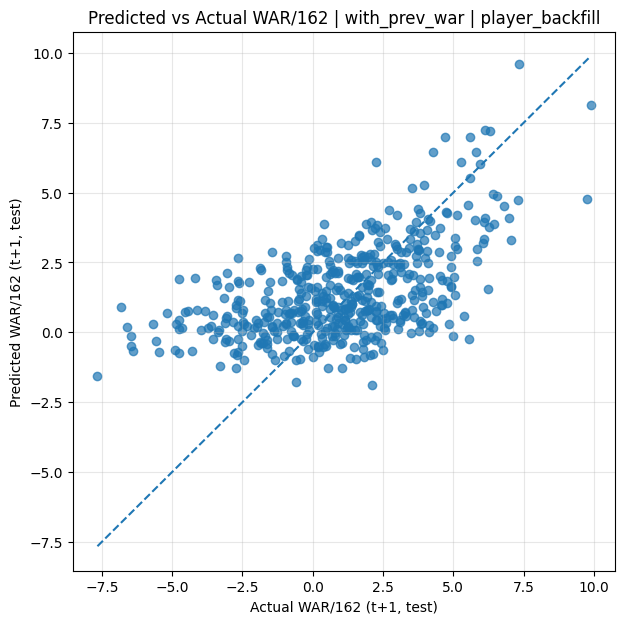

In [188]:
y_test = best_res['y_test']
y_pred = best_res['y_test_pred']
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual WAR/162 (t+1, test)')
plt.ylabel('Predicted WAR/162 (t+1, test)')
plt.title(f"Predicted vs Actual WAR/162 | {best_res['feature_mode']} | {best_res['bat_strategy']}")
plt.grid(True, alpha=0.3)
plt.show()

In [189]:
# Get the test panel data for the best model
if best_res['bat_strategy'] == 'player_backfill':
    test_panel_used = test_panel_backfill
else:
    test_panel_used = test_panel_raw

# Get the subset that was actually used in testing (after dropping missing targets)
test_subset = test_panel_used.dropna(subset=['WAR_per_162_next']).copy()

# Create a results dataframe (include AB for qualifier analysis)
results_df = test_subset[['Name', 'mlbID', 'Season', 'Season_next', 'Age', 'G', 'PA', 'AB', 'WAR', 'WAR_per_162', 
                          'BA', 'OBP', 'SLG', 'OPS', 'HR', 'RBI', 'BB', 'SO']].copy()

# Add predictions and errors
results_df['Actual_WAR_per_162_next'] = best_res['y_test']
results_df['Predicted_WAR_per_162_next'] = best_res['y_test_pred']
results_df['Error'] = results_df['Predicted_WAR_per_162_next'] - results_df['Actual_WAR_per_162_next']
results_df['Abs_Error'] = results_df['Error'].abs()

# Sort by absolute error to find best and worst predictions
results_df_sorted = results_df.sort_values('Abs_Error')

print("=" * 80)
print("BEST PREDICTIONS (Smallest Errors)")
print("=" * 80)
print("\nTop 10 Best Predictions:\n")
best_10 = results_df_sorted.head(10)
for idx, row in best_10.iterrows():
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  Actual:   {row['Actual_WAR_per_162_next']:6.2f} | Predicted: {row['Predicted_WAR_per_162_next']:6.2f} | Error: {row['Error']:6.2f}")
    print(f"  Year t:   WAR={row['WAR']:5.2f}, WAR/162={row['WAR_per_162']:5.2f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print()

print("\n" + "=" * 80)
print("WORST PREDICTIONS (Largest Errors)")
print("=" * 80)
print("\nTop 10 Worst Predictions:\n")
worst_10 = results_df_sorted.tail(10).iloc[::-1]  # Reverse to show worst first
for idx, row in worst_10.iterrows():
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  Actual:   {row['Actual_WAR_per_162_next']:6.2f} | Predicted: {row['Predicted_WAR_per_162_next']:6.2f} | Error: {row['Error']:6.2f}")
    print(f"  Year t:   WAR={row['WAR']:5.2f}, WAR/162={row['WAR_per_162']:5.2f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print()


BEST PREDICTIONS (Smallest Errors)

Top 10 Best Predictions:

Xander Bogaerts           | Age 31 | Season 2024→2025
  Actual:     2.32 | Predicted:   2.33 | Error:   0.01
  Year t:   WAR= 1.21, WAR/162= 1.66, OPS=0.681, HR=12

Alexander Canario         | Age 24 | Season 2024→2025
  Actual:     0.91 | Predicted:   0.89 | Error:  -0.02
  Year t:   WAR= 0.29, WAR/162= 3.13, OPS=0.797, HR=1

Austin Slater             | Age 31 | Season 2024→2025
  Actual:    -0.25 | Predicted:  -0.23 | Error:   0.02
  Year t:   WAR=-0.20, WAR/162=-0.38, OPS=0.591, HR=2

J.P. Crawford             | Age 29 | Season 2024→2025
  Actual:     3.59 | Predicted:   3.61 | Error:   0.02
  Year t:   WAR= 2.72, WAR/162= 4.20, OPS=0.625, HR=9

Alejandro Kirk            | Age 25 | Season 2024→2025
  Actual:     2.51 | Predicted:   2.49 | Error:  -0.02
  Year t:   WAR= 2.00, WAR/162= 3.15, OPS=0.677, HR=5

Brandon Nimmo             | Age 31 | Season 2024→2025
  Actual:     3.01 | Predicted:   2.98 | Error:  -0.03
  Year t

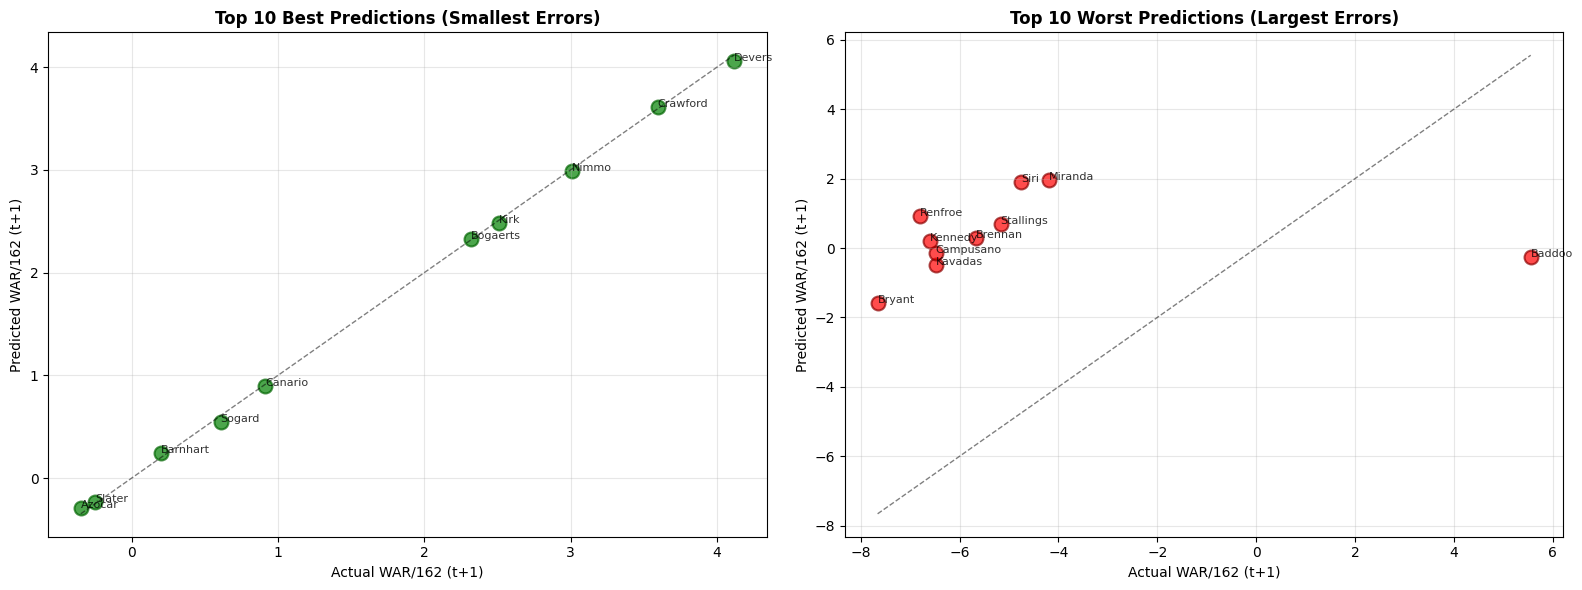


SUMMARY STATISTICS

Best 10 predictions:
  Mean absolute error: 0.032
  Mean error: -0.004

Worst 10 predictions:
  Mean absolute error: 6.335
  Mean error: 5.176

Overall test set:
  Mean absolute error: 1.861
  RMSE: 2.346


In [190]:
# Visualize best and worst predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Best predictions
ax1 = axes[0]
best_10 = results_df_sorted.head(10)
ax1.scatter(best_10['Actual_WAR_per_162_next'], best_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.7, color='green', edgecolors='darkgreen', linewidth=1.5)
for idx, row in best_10.iterrows():
    ax1.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=8, alpha=0.8)
lims1 = [min(best_10['Actual_WAR_per_162_next'].min(), best_10['Predicted_WAR_per_162_next'].min()),
         max(best_10['Actual_WAR_per_162_next'].max(), best_10['Predicted_WAR_per_162_next'].max())]
ax1.plot(lims1, lims1, 'k--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Actual WAR/162 (t+1)')
ax1.set_ylabel('Predicted WAR/162 (t+1)')
ax1.set_title('Top 10 Best Predictions (Smallest Errors)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Worst predictions
ax2 = axes[1]
worst_10 = results_df_sorted.tail(10)
ax2.scatter(worst_10['Actual_WAR_per_162_next'], worst_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.7, color='red', edgecolors='darkred', linewidth=1.5)
for idx, row in worst_10.iterrows():
    ax2.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=8, alpha=0.8)
lims2 = [min(worst_10['Actual_WAR_per_162_next'].min(), worst_10['Predicted_WAR_per_162_next'].min()),
         max(worst_10['Actual_WAR_per_162_next'].max(), worst_10['Predicted_WAR_per_162_next'].max())]
ax2.plot(lims2, lims2, 'k--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Actual WAR/162 (t+1)')
ax2.set_ylabel('Predicted WAR/162 (t+1)')
ax2.set_title('Top 10 Worst Predictions (Largest Errors)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nBest 10 predictions:")
print(f"  Mean absolute error: {best_10['Abs_Error'].mean():.3f}")
print(f"  Mean error: {best_10['Error'].mean():.3f}")
print(f"\nWorst 10 predictions:")
print(f"  Mean absolute error: {worst_10['Abs_Error'].mean():.3f}")
print(f"  Mean error: {worst_10['Error'].mean():.3f}")
print(f"\nOverall test set:")
print(f"  Mean absolute error: {results_df['Abs_Error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((results_df['Error']**2).mean()):.3f}")


In [191]:
# Add AB column to results_df if it's missing (needed for qualifier analysis)
if 'AB' not in results_df.columns:
    # Get the test panel data for the best model
    if best_res['bat_strategy'] == 'player_backfill':
        test_panel_used = test_panel_backfill
    else:
        test_panel_used = test_panel_raw
    
    test_subset_for_ab = test_panel_used.dropna(subset=['WAR_per_162_next']).copy()
    ab_from_test = test_subset_for_ab[['mlbID', 'Season', 'AB']].copy()
    
    # Merge AB into results_df
    results_df = results_df.merge(
        ab_from_test[['mlbID', 'Season', 'AB']],
        on=['mlbID', 'Season'],
        how='left'
    )


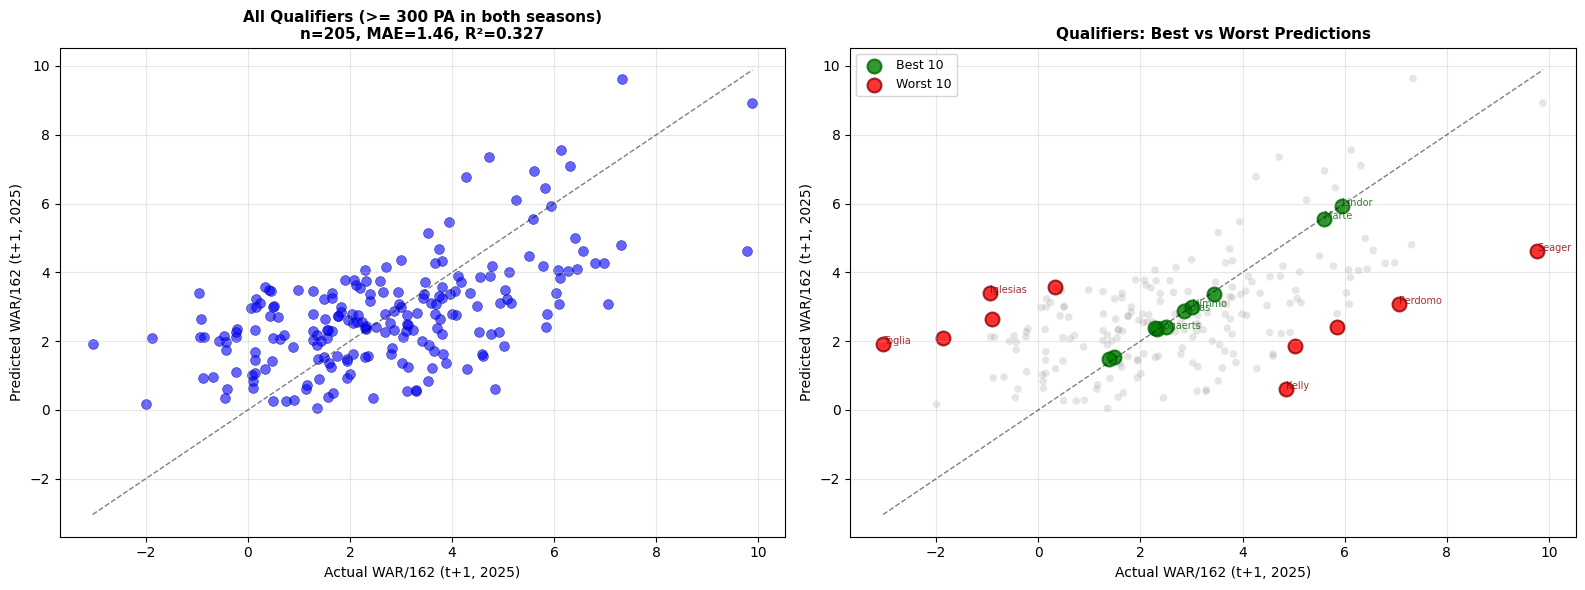


COMPARISON: QUALIFIERS vs NON-QUALIFIERS

Qualifiers (>= 300 PA in both seasons):
  Count: 205
  Mean Absolute Error: 1.457
  RMSE: 1.789
  R²: 0.327

Non-Qualifiers:
  Count: 293
  Mean Absolute Error: 2.194
  RMSE: 2.730
  R²: -0.106


In [192]:
# Visualize qualifier predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All qualifiers scatter plot
ax1 = axes[0]
ax1.scatter(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next'], 
            alpha=0.6, s=50, color='blue', edgecolors='darkblue', linewidth=0.5)
lims1 = [min(qualifiers_pa['Actual_WAR_per_162_next'].min(), qualifiers_pa['Predicted_WAR_per_162_next'].min()),
         max(qualifiers_pa['Actual_WAR_per_162_next'].max(), qualifiers_pa['Predicted_WAR_per_162_next'].max())]
ax1.plot(lims1, lims1, 'k--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Actual WAR/162 (t+1, 2025)')
ax1.set_ylabel('Predicted WAR/162 (t+1, 2025)')
ax1.set_title(f'All Qualifiers (>= {min_pa} PA in both seasons)\n' + 
              f'n={len(qualifiers_pa)}, MAE={qualifiers_pa["Abs_Error"].mean():.2f}, ' +
              f'R²={r2_score(qualifiers_pa["Actual_WAR_per_162_next"], qualifiers_pa["Predicted_WAR_per_162_next"]):.3f}',
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Best and worst qualifiers highlighted
ax2 = axes[1]
# Plot all qualifiers in light gray
ax2.scatter(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next'], 
            alpha=0.2, s=30, color='gray', edgecolors='none')
# Highlight best 10
ax2.scatter(best_qual_10['Actual_WAR_per_162_next'], best_qual_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.8, color='green', edgecolors='darkgreen', linewidth=1.5, label='Best 10')
# Highlight worst 10
ax2.scatter(worst_qual_10['Actual_WAR_per_162_next'], worst_qual_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.8, color='red', edgecolors='darkred', linewidth=1.5, label='Worst 10')
# Annotate best and worst
for idx, row in best_qual_10.head(5).iterrows():  # Top 5 best
    ax2.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=7, alpha=0.8, color='darkgreen')
for idx, row in worst_qual_10.head(5).iterrows():  # Top 5 worst
    ax2.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=7, alpha=0.8, color='darkred')
lims2 = [min(qualifiers_pa['Actual_WAR_per_162_next'].min(), qualifiers_pa['Predicted_WAR_per_162_next'].min()),
         max(qualifiers_pa['Actual_WAR_per_162_next'].max(), qualifiers_pa['Predicted_WAR_per_162_next'].max())]
ax2.plot(lims2, lims2, 'k--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Actual WAR/162 (t+1, 2025)')
ax2.set_ylabel('Predicted WAR/162 (t+1, 2025)')
ax2.set_title(f'Qualifiers: Best vs Worst Predictions', fontsize=11, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare qualifiers vs non-qualifiers
non_qualifiers = results_df_with_t1[
    ~((results_df_with_t1['PA'] >= min_pa) & (results_df_with_t1['PA_next'] >= min_pa))
].copy()
non_qualifiers['Error'] = non_qualifiers['Predicted_WAR_per_162_next'] - non_qualifiers['Actual_WAR_per_162_next']
non_qualifiers['Abs_Error'] = non_qualifiers['Error'].abs()

print("\n" + "=" * 80)
print("COMPARISON: QUALIFIERS vs NON-QUALIFIERS")
print("=" * 80)
print(f"\nQualifiers (>= {min_pa} PA in both seasons):")
print(f"  Count: {len(qualifiers_pa)}")
print(f"  Mean Absolute Error: {qualifiers_pa['Abs_Error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((qualifiers_pa['Error']**2).mean()):.3f}")
print(f"  R²: {r2_score(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next']):.3f}")
print(f"\nNon-Qualifiers:")
print(f"  Count: {len(non_qualifiers)}")
print(f"  Mean Absolute Error: {non_qualifiers['Abs_Error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((non_qualifiers['Error']**2).mean()):.3f}")
print(f"  R²: {r2_score(non_qualifiers['Actual_WAR_per_162_next'], non_qualifiers['Predicted_WAR_per_162_next']):.3f}")


In [193]:
# Calculate WAR change from 2024 to 2025
results_df_with_t1['WAR_change'] = results_df_with_t1['Actual_WAR_per_162_next'] - results_df_with_t1['WAR_per_162']
results_df_with_t1['Predicted_WAR_change'] = results_df_with_t1['Predicted_WAR_per_162_next'] - results_df_with_t1['WAR_per_162']
results_df_with_t1['Change_Error'] = results_df_with_t1['Predicted_WAR_change'] - results_df_with_t1['WAR_change']
results_df_with_t1['Abs_Change_Error'] = results_df_with_t1['Change_Error'].abs()

# Sort by absolute WAR change to find biggest jumps
results_df_with_t1_sorted = results_df_with_t1.sort_values('WAR_change', key=abs, ascending=False)

print("=" * 80)
print("BIGGEST WAR JUMPS FROM 2024 TO 2025")
print("=" * 80)

# Show top 20 biggest jumps (both positive and negative)
print("\nTop 20 Biggest WAR Changes (Positive and Negative):\n")
biggest_changes = results_df_with_t1_sorted.head(20)
for idx, row in biggest_changes.iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | {direction} {abs(row['WAR_change']):5.2f} WAR")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print(f"  Predicted Change: {row['Predicted_WAR_change']:6.2f} | Actual Change: {row['WAR_change']:6.2f} | Error: {row['Change_Error']:6.2f}")
    print()

# Focus on qualifiers with big jumps
qualifiers_with_t1 = results_df_with_t1[
    (results_df_with_t1['PA'] >= 300) & 
    (results_df_with_t1['PA_next'] >= 300)
].copy()
qualifiers_with_t1['WAR_change'] = qualifiers_with_t1['Actual_WAR_per_162_next'] - qualifiers_with_t1['WAR_per_162']
qualifiers_with_t1['Predicted_WAR_change'] = qualifiers_with_t1['Predicted_WAR_per_162_next'] - qualifiers_with_t1['WAR_per_162']
qualifiers_with_t1['Change_Error'] = qualifiers_with_t1['Predicted_WAR_change'] - qualifiers_with_t1['WAR_change']
qualifiers_with_t1_sorted = qualifiers_with_t1.sort_values('WAR_change', key=abs, ascending=False)

print("\n" + "=" * 80)
print("BIGGEST WAR JUMPS FOR QUALIFIERS (>= 300 PA in both seasons)")
print("=" * 80)

print("\nTop 15 Biggest WAR Changes for Qualifiers:\n")
qualifier_big_changes = qualifiers_with_t1_sorted.head(15)
for idx, row in qualifier_big_changes.iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | {direction} {abs(row['WAR_change']):5.2f} WAR")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print(f"  Predicted Change: {row['Predicted_WAR_change']:6.2f} | Actual Change: {row['WAR_change']:6.2f} | Error: {row['Change_Error']:6.2f}")
    print()

# Find cases where model predicted a big jump and it happened
print("\n" + "=" * 80)
print("CASES WHERE MODEL PREDICTED BIG JUMPS AND THEY HAPPENED")
print("=" * 80)

# Filter for cases where both predicted and actual changes are significant (>= 2.0 WAR)
predicted_big_jumps = results_df_with_t1[
    (results_df_with_t1['Predicted_WAR_change'].abs() >= 2.0) &
    (results_df_with_t1['WAR_change'].abs() >= 2.0)
].copy()
predicted_big_jumps = predicted_big_jumps.sort_values('WAR_change', key=abs, ascending=False)

# Separate positive and negative jumps
positive_jumps = predicted_big_jumps[predicted_big_jumps['WAR_change'] > 0].sort_values('WAR_change', ascending=False)
negative_jumps = predicted_big_jumps[predicted_big_jumps['WAR_change'] < 0].sort_values('WAR_change', ascending=True)

print(f"\nTotal cases where model predicted big jump (>=2.0 WAR) and it happened: {len(predicted_big_jumps)}")
print(f"  Positive jumps (improvements): {len(positive_jumps)}")
print(f"  Negative jumps (declines): {len(negative_jumps)}")

print("\n" + "-" * 80)
print("POSITIVE JUMPS (Model Predicted Improvement and It Happened)")
print("-" * 80)
for idx, row in positive_jumps.iterrows():
    print(f"\n{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  WAR Change: ↑ {row['WAR_change']:5.2f} (Predicted: ↑ {row['Predicted_WAR_change']:5.2f})")
    print(f"  2024 Stats: WAR/162={row['WAR_per_162']:6.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}, BA={row['BA']:.3f}")
    print(f"  2025 Results: Actual={row['Actual_WAR_per_162_next']:6.2f} | Predicted={row['Predicted_WAR_per_162_next']:6.2f} | Error={row['Change_Error']:6.2f}")
    if pd.notna(row['PA_next']):
        print(f"  2025 PA: {row['PA_next']:.0f}")

print("\n" + "-" * 80)
print("NEGATIVE JUMPS (Model Predicted Decline and It Happened)")
print("-" * 80)
for idx, row in negative_jumps.iterrows():
    print(f"\n{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  WAR Change: ↓ {abs(row['WAR_change']):5.2f} (Predicted: ↓ {abs(row['Predicted_WAR_change']):5.2f})")
    print(f"  2024 Stats: WAR/162={row['WAR_per_162']:6.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}, BA={row['BA']:.3f}")
    print(f"  2025 Results: Actual={row['Actual_WAR_per_162_next']:6.2f} | Predicted={row['Predicted_WAR_per_162_next']:6.2f} | Error={row['Change_Error']:6.2f}")
    if pd.notna(row['PA_next']):
        print(f"  2025 PA: {row['PA_next']:.0f}")

# Find cases where model predicted a big jump but it didn't happen
print("\n" + "=" * 80)
print("CASES WHERE MODEL PREDICTED BIG JUMPS BUT THEY DIDN'T HAPPEN")
print("=" * 80)

predicted_but_not_actual = results_df_with_t1[
    (results_df_with_t1['Predicted_WAR_change'].abs() >= 2.0) &
    (results_df_with_t1['WAR_change'].abs() < 1.0)
].copy()
predicted_but_not_actual = predicted_but_not_actual.sort_values('Predicted_WAR_change', key=abs, ascending=False)

print(f"\nPlayers where model predicted big jump (>=2.0 WAR) but actual change was small (<1.0 WAR):\n")
for idx, row in predicted_but_not_actual.head(10).iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Predicted {row['Predicted_WAR_change']:6.2f}, Actual {row['WAR_change']:6.2f}")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print()

# Find cases where big jumps happened but model didn't predict them
print("\n" + "=" * 80)
print("CASES WHERE BIG JUMPS HAPPENED BUT MODEL DIDN'T PREDICT THEM")
print("=" * 80)

actual_but_not_predicted = results_df_with_t1[
    (results_df_with_t1['WAR_change'].abs() >= 2.0) &
    (results_df_with_t1['Predicted_WAR_change'].abs() < 1.0)
].copy()
actual_but_not_predicted = actual_but_not_predicted.sort_values('WAR_change', key=abs, ascending=False)

print(f"\nPlayers where big jump happened (>=2.0 WAR) but model predicted small change (<1.0 WAR):\n")
for idx, row in actual_but_not_predicted.head(10).iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | {direction} {abs(row['WAR_change']):5.2f} WAR")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print(f"  Predicted Change: {row['Predicted_WAR_change']:6.2f} | Actual Change: {row['WAR_change']:6.2f}")
    print()


BIGGEST WAR JUMPS FROM 2024 TO 2025

Top 20 Biggest WAR Changes (Positive and Negative):

Nacho Alvarez Jr.         | Age 21 | ↑ 12.86 WAR
  2024: WAR/162=-10.73, PA=  32, OPS=0.256, HR=0
  2025: Actual= 2.12 | Predicted=-1.37
  Predicted Change:   9.36 | Actual Change:  12.86 | Error:  -3.50

Buddy Kennedy             | Age 25 | ↓  8.85 WAR
  2024: WAR/162= 2.24, PA=  26, OPS=0.689, HR=1
  2025: Actual=-6.60 | Predicted= 0.37
  Predicted Change:  -1.87 | Actual Change:  -8.85 | Error:   6.98

Rece Hinds                | Age 23 | ↓  8.83 WAR
  2024: WAR/162= 4.72, PA=  51, OPS=1.051, HR=5
  2025: Actual=-4.10 | Predicted= 0.99
  Predicted Change:  -3.73 | Actual Change:  -8.83 | Error:   5.10

Keston Hiura              | Age 27 | ↑  8.79 WAR
  2024: WAR/162=-9.40, PA=  27, OPS=0.296, HR=0
  2025: Actual=-0.61 | Predicted=-1.07
  Predicted Change:   8.32 | Actual Change:   8.79 | Error:  -0.46

Bryce Teodosio            | Age 25 | ↑  8.65 WAR
  2024: WAR/162=-7.13, PA=  12, OPS=0.167, H

## 14. Save Best Model for Roster Optimizer

Save the best model (ElasticNet with `with_prev_war`) along with preprocessing objects for use in the roster optimizer.


In [194]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Use the best model from experiments (already trained with proper preprocessing)
best_feature_mode = best_res['feature_mode']
best_bat_strategy = best_res['bat_strategy']

# Save the best model and its preprocessing objects
model_artifacts = {
    'model': best_res['model'],
    'imputer': best_res['imputer'],
    'scaler': best_res['scaler'],
    'onehot_encoder': best_res['onehot_encoder'],
    'feature_names': best_res['feature_names'],
    'feature_mode': best_feature_mode,
    'bat_strategy': best_bat_strategy,
    'min_pa_train': MIN_PA_TRAIN,
    'alpha': best_res['alpha'],  # Tuned alpha from CV
    'l1_ratio': best_res['l1_ratio'],  # Tuned l1_ratio from CV
}

joblib.dump(model_artifacts, 'models/hitter_war_model_newest.joblib')
print(f"Saved hitter WAR model to 'models/hitter_war_model_newest.joblib'")
print(f"  Feature mode: {best_feature_mode}")
print(f"  Bat strategy: {best_bat_strategy}")
print(f"  Min PA (train): {MIN_PA_TRAIN}")
print(f"  Features: {len(best_res['feature_names'])}")
print(f"  Test R²: {best_res['test_r2']:.3f}")
print(f"  Tuned alpha: {best_res['alpha']:.4f}")
print(f"  Tuned l1_ratio: {best_res['l1_ratio']:.3f}")

Saved hitter WAR model to 'models/hitter_war_model_newest.joblib'
  Feature mode: with_prev_war
  Bat strategy: player_backfill
  Min PA (train): 200
  Features: 85
  Test R²: 0.296
  Tuned alpha: 0.0183
  Tuned l1_ratio: 0.300
